<a href="https://colab.research.google.com/github/emukans/en-lv-translator/blob/master/bert_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Encode text embeddings with pre-trained BERT model using MS-COCO dataset

In [0]:
import tensorflow as tf
import tensorflow_hub as hub

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import collections

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

import pandas as pd
from datetime import datetime

Using TensorFlow backend.


In [0]:
tfe = tf.contrib.eager
tfe.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Configuration

In [0]:
sess = tf.Session()

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 128

In [0]:
# Available pretrained model checkpoints:
#   uncased_L-12_H-768_A-12: uncased BERT base model
#   uncased_L-24_H-1024_A-16: uncased BERT large model
#   cased_L-12_H-768_A-12: cased BERT large model
#   multi_cased_L-12_H-768_A-12: cased multilingual
BERT_MODEL = 'uncased_L-12_H-768_A-12'
BERT_PRETRAINED_DIR = 'gs://cloud-tpu-checkpoints/bert/' + BERT_MODEL

LAYERS = [-1,-2,-3,-4]  # Take into account only last 4 layers
NUM_TPU_CORES = 8
MAX_SEQ_LENGTH = 128
BERT_CONFIG = BERT_PRETRAINED_DIR + '/bert_config.json'
CHKPT_DIR = BERT_PRETRAINED_DIR + '/bert_model.ckpt'
VOCAB_FILE = BERT_PRETRAINED_DIR + '/vocab.txt'
INIT_CHECKPOINT = BERT_PRETRAINED_DIR + '/bert_model.ckpt'
BATCH_SIZE = 128
MAX_DIMENSION = 768  # 1024 for Large model


TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']

KeyError: ignored

##Prepare MS-COCO dataset

###Load BERT embeddings if exists

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [0]:
word_embeddings = np.load('gdrive/My Drive/bert_translate/cls.npy')

###Download data

In [0]:
# !gcloud auth application-default login
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?code_challenge=70tXUF6iF8OMI0swUpa3Fm_IdNII5Clpuk8-SBeLkSs&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


Enter verification code: 4/xwHtHGnCaIu1H36y8F4V1jHwkdozf4Tl1U_E07qsA6d1iABHTJNVZYo

You are now logged in as [eduardmukan@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [0]:
import zipfile

!gsutil -m cp gs://translator-lv-en/annotations.zip annotations.zip

with zipfile.ZipFile('annotations.zip', 'r') as zip_ref:
    zip_ref.extractall()

Copying gs://translator-lv-en/annotations.zip...
/ [1/1 files][ 17.1 MiB/ 17.1 MiB] 100% Done                                    
Operation completed over 1 objects/17.1 MiB.                                     


###Preprocess data

In [0]:
raw_en_annotations = []
annotation_en_file = 'annotations/annotations.en'
with open(annotation_en_file, 'r') as f:
    raw_en_annotations = f.readlines()

def prepare_caption(caption: str):
  return f'<start> {caption.strip()} <end>'

prepared_en_caption_list = shuffle(raw_en_annotations[:30000], random_state=1)
prepared_en_caption_list = [prepare_caption(caption) for caption in prepared_en_caption_list]

raw_lv_annotations = []
annotation_lv_file = 'annotations/annotations.lv'
with open(annotation_lv_file, 'r') as f:
    raw_lv_annotations = f.readlines()

prepared_lv_caption_list = shuffle(raw_lv_annotations[:30000], random_state=1)
prepared_lv_caption_list = [prepare_caption(caption) for caption in prepared_lv_caption_list]

In [0]:
prepared_en_caption_list[0]

'<start> A herd of cattle laying in the grass on the ground. <end>'

##Prepare BERT pretrained model

In [0]:
!pip install bert-tensorflow

In [0]:
from bert import optimization, tokenization, modeling, extract_features

In [0]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = f"https://tfhub.dev/google/bert_{BERT_MODEL}/1"

def build_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = build_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


###Convert texts to input examples

In [0]:
# input_example_list = [extract_features.InputExample(unique_id=unique_id, text_a=text, text_b=prepared_lv_caption_list[unique_id]) for unique_id, text in enumerate(prepared_en_caption_list)]
input_example_list = [extract_features.InputExample(unique_id=unique_id, text_a=text, text_b='') for unique_id, text in enumerate(prepared_en_caption_list)]

### Convert input examples to features

In [0]:
feature_list = extract_features.convert_examples_to_features(input_example_list, MAX_SEQ_LENGTH, tokenizer)
unique_id_to_feature = {feature.unique_id: feature for feature in feature_list}

INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:unique_id: 0


INFO:tensorflow:unique_id: 0


INFO:tensorflow:tokens: [CLS] < start > a herd of cattle laying in the grass on the ground . < end > [SEP]


INFO:tensorflow:tokens: [CLS] < start > a herd of cattle laying in the grass on the ground . < end > [SEP]


INFO:tensorflow:input_ids: 101 1026 2707 1028 1037 14906 1997 7125 10201 1999 1996 5568 2006 1996 2598 1012 1026 2203 1028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1026 2707 1028 1037 14906 1997 7125 10201 1999 1996 5568 2006 1996 2598 1012 1026 2203 1028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:unique_id: 1


INFO:tensorflow:unique_id: 1


INFO:tensorflow:tokens: [CLS] < start > a toilet is placed on the check ##ered bathroom floor . < end > [SEP]


INFO:tensorflow:tokens: [CLS] < start > a toilet is placed on the check ##ered bathroom floor . < end > [SEP]


INFO:tensorflow:input_ids: 101 1026 2707 1028 1037 11848 2003 2872 2006 1996 4638 6850 5723 2723 1012 1026 2203 1028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1026 2707 1028 1037 11848 2003 2872 2006 1996 4638 6850 5723 2723 1012 1026 2203 1028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:unique_id: 2


INFO:tensorflow:unique_id: 2


INFO:tensorflow:tokens: [CLS] < start > a boat and a duck is in the water < end > [SEP]


INFO:tensorflow:tokens: [CLS] < start > a boat and a duck is in the water < end > [SEP]


INFO:tensorflow:input_ids: 101 1026 2707 1028 1037 4049 1998 1037 9457 2003 1999 1996 2300 1026 2203 1028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1026 2707 1028 1037 4049 1998 1037 9457 2003 1999 1996 2300 1026 2203 1028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:unique_id: 3


INFO:tensorflow:unique_id: 3


INFO:tensorflow:tokens: [CLS] < start > a passenger jet flying over a building on a cloudy day . < end > [SEP]


INFO:tensorflow:tokens: [CLS] < start > a passenger jet flying over a building on a cloudy day . < end > [SEP]


INFO:tensorflow:input_ids: 101 1026 2707 1028 1037 4628 6892 3909 2058 1037 2311 2006 1037 24706 2154 1012 1026 2203 1028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1026 2707 1028 1037 4628 6892 3909 2058 1037 2311 2006 1037 24706 2154 1012 1026 2203 1028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:unique_id: 4


INFO:tensorflow:unique_id: 4


INFO:tensorflow:tokens: [CLS] < start > a large bathroom has a bath ##tub , sink , and two toilets . < end > [SEP]


INFO:tensorflow:tokens: [CLS] < start > a large bathroom has a bath ##tub , sink , and two toilets . < end > [SEP]


INFO:tensorflow:input_ids: 101 1026 2707 1028 1037 2312 5723 2038 1037 7198 28251 1010 7752 1010 1998 2048 21674 1012 1026 2203 1028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1026 2707 1028 1037 2312 5723 2038 1037 7198 28251 1010 7752 1010 1998 2048 21674 1012 1026 2203 1028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


### Create model and input builders closures to be passed to TPU estimator

In [0]:
bert_config = modeling.BertConfig.from_json_file(BERT_CONFIG)
layer_indexes = LAYERS

model_fn = extract_features.model_fn_builder(
      bert_config=bert_config,
      init_checkpoint=INIT_CHECKPOINT,
      layer_indexes=layer_indexes,
      use_tpu=True,
      use_one_hot_embeddings=True)

In [0]:
is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    tpu_config=tf.contrib.tpu.TPUConfig(
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=is_per_host))

input_fn = extract_features.input_fn_builder(features=feature_list, seq_length=MAX_SEQ_LENGTH)

###Create TPU estimator

In [0]:
estimator = tf.contrib.tpu.TPUEstimator(
      use_tpu=True,
      model_fn=model_fn,
      config=run_config,
      predict_batch_size=BATCH_SIZE,
      train_batch_size=BATCH_SIZE)

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpz52geirb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.119.120.130:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f21ca51d9e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.119.120.130:8470', '_evaluation_master': 'grpc://10.119.120.130:8470', '_is_chief': True, '_num_ps_replicas': 0, '_nu

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpz52geirb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.119.120.130:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f21ca51d9e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.119.120.130:8470', '_evaluation_master': 'grpc://10.119.120.130:8470', '_is_chief': True, '_num_ps_replicas': 0, '_nu

INFO:tensorflow:_TPUContext: eval_on_tpu True


INFO:tensorflow:_TPUContext: eval_on_tpu True


##Calculate word embeddings

In [0]:
word_embeddings = []
for result in estimator.predict(input_fn, yield_single_examples=True):
    unique_id = int(result["unique_id"])
    feature = unique_id_to_feature[unique_id]
    output = collections.OrderedDict()
    for (i, token) in enumerate(feature.tokens):
      layers = []
      for (j, layer_index) in enumerate(layer_indexes):
        layer_output = result["layer_output_%d" % j]
        layer_output_flat = np.array([x for x in layer_output[i:(i + 1)].flat])
        layers.append(layer_output_flat)
      output[token] = sum(layers)[:MAX_DIMENSION]
      
    word_embeddings.append(output)

INFO:tensorflow:Could not find trained model in model_dir: /tmp/tmpz52geirb, running initialization to predict.


INFO:tensorflow:Could not find trained model in model_dir: /tmp/tmpz52geirb, running initialization to predict.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Querying Tensorflow master (grpc://10.119.120.130:8470) for TPU system metadata.


INFO:tensorflow:Querying Tensorflow master (grpc://10.119.120.130:8470) for TPU system metadata.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 15415656055414200254)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 15415656055414200254)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9601587432569054518)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9601587432569054518)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 11892515732639398284)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 11892515732639398284)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2595762303508373315)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2595762303508373315)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 16703918823402420833)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 16703918823402420833)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 16531021712354762086)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 16531021712354762086)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 14235218076078047828)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 14235218076078047828)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 6410000741292106462)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 6410000741292106462)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 8761853745286607032)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 8761853745286607032)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 10431372023528708021)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 10431372023528708021)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1551880155621879636)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1551880155621879636)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


INFO:tensorflow:**** Trainable Variables ****


INFO:tensorflow:**** Trainable Variables ****


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (30522, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (30522, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 8 seconds


INFO:tensorflow:Initialized TPU in 8 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 1 seconds


INFO:tensorflow:Initialized dataset iterators in 1 seconds


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (33, 0)


INFO:tensorflow:Outfeed finished for iteration (33, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (69, 0)


INFO:tensorflow:Outfeed finished for iteration (69, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (106, 0)


INFO:tensorflow:Outfeed finished for iteration (106, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (142, 0)


INFO:tensorflow:Outfeed finished for iteration (142, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (178, 0)


INFO:tensorflow:Outfeed finished for iteration (178, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (214, 0)


INFO:tensorflow:Outfeed finished for iteration (214, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


In [0]:
# np.save('test', [word['[CLS]'] for word in word_embeddings])
word_embeddings = [word['[CLS]'] for word in word_embeddings]
np.save('gdrive/My Drive/bert_translate/cls.npy', word_embeddings)

##Part from image captioning

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [0]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(prepared_en_caption_list)
train_seqs = tokenizer.texts_to_sequences(prepared_en_caption_list)

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(prepared_en_caption_list)

In [0]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [0]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [0]:
# Create training and validation sets using an 80-20 split
word_train, word_val, cap_train, cap_val = train_test_split(word_embeddings,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [0]:
len(word_train), len(cap_train), len(word_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Create a tf.data dataset for training


In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(word_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 768
# attention_features_shape = 64

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((word_train, cap_train))


# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [0]:
checkpoint_path = "./gdrive/My Drive/bert_translate/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [0]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  # dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      # predictions, hidden, _ = decoder(dec_input, features, hidden)
      # loss += loss_function(target, predictions)
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  # total_loss = loss

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [0]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 5 Batch 0 Loss 2.1591
Epoch 5 Batch 100 Loss 1.0970
Epoch 5 Batch 200 Loss 0.9510
Epoch 5 Batch 300 Loss 0.8998
Epoch 5 Loss 1.006419
Time taken for 1 epoch 577.6511623859406 sec

Epoch 6 Batch 0 Loss 0.9172
Epoch 6 Batch 100 Loss 0.9613
Epoch 6 Batch 200 Loss 0.8366
Epoch 6 Batch 300 Loss 0.8162
Epoch 6 Loss 0.865082
Time taken for 1 epoch 359.43321084976196 sec

Epoch 7 Batch 0 Loss 0.8558
Epoch 7 Batch 100 Loss 0.8899
Epoch 7 Batch 200 Loss 0.7767
Epoch 7 Batch 300 Loss 0.7580
Epoch 7 Loss 0.809748
Time taken for 1 epoch 357.6312925815582 sec

Epoch 8 Batch 0 Loss 0.8204
Epoch 8 Batch 100 Loss 0.8382
Epoch 8 Batch 200 Loss 0.7380
Epoch 8 Batch 300 Loss 0.7313
Epoch 8 Loss 0.776095
Time taken for 1 epoch 357.53607296943665 sec

Epoch 9 Batch 0 Loss 0.7932
Epoch 9 Batch 100 Loss 0.8040
Epoch 9 Batch 200 Loss 0.7186
Epoch 9 Batch 300 Loss 0.7116
Epoch 9 Loss 0.751830
Time taken for 1 epoch 357.1628267765045 sec

Epoch 10 Batch 0 Loss 0.7846
Epoch 10 Batch 100 Loss 0.7775
Epoch 10

In [0]:
np.save('gdrive/My Drive/bert_translate/loss_plot', loss_plot)

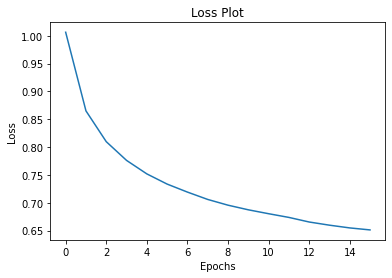

In [0]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show() 

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [0]:
def evaluate(word):
    # attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    word_tensor_val = tf.expand_dims(word, 0)
    # img_tensor_val = image_features_extract_model(temp_input)
    # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    # word_tensor_val = tf.reshape(word, (word.shape[1], -1))

    features = encoder(word_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            # return result, attention_plot
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    # attention_plot = attention_plot[:len(result), :]
    # return result, attention_plot
    return result

In [0]:
# captions on the validation set
rid = np.random.randint(0, len(word_val))
word = word_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result = evaluate(word)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))


Real Caption: <start> a large crowd of people standing an a street <end>
Prediction Caption: a living room scene of a modern looking at table with two aircraft flying men standing by girl in two white cats fly kites flying a bathroom towels are many people are only lights of a black and yellow baskets are many cups and counter that is a pink
